# Prediction of back pain using Logistic Regression, Python

The data comprises of 13 columns and 310 observations. 12 columns are numerical attributes of the spine/ back. The last column is the Status of the patient - Abnormal indicates presence of Back pain and Normal indicates no back pain. The intent is to predict the Status based on the 12 variables. 

In this kernel, I explore the different variables and use Logistic Regression to predict and understand the causal effects of the different predictors.

In [0]:
#Loading the necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# print(os.listdir("../input"))

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [0]:
back_data = pd.read_csv("Dataset_spine.csv")

## Unnamed column names

 - There is an additional column with notes about the names of each of the individual attributes. This is removed.
 - The columns are not named in the dataset. Adding the column names to each of the corresponding columns. 

In [0]:
del back_data['Unnamed: 13']
back_data.columns = ['pelvic_incidence','pelvic tilt','lumbar_lordosis_angle','sacral_slope','pelvic_radius','degree_spondylolisthesis','pelvic_slope','Direct_tilt','thoracic_slope','cervical_tilt','sacrum_angle','scoliosis_slope','Status']

## Initial Data Exploration
 - Checking if there are any missing values in the dataset. Turns out there aren't any.
 - Checking the frequency of the different values of the Status column. Abnormal is 210 of the 310 observations. This means that it is not really an unbalanced dataset.

In [0]:
## Understanding the structure of the data variables
back_data.info()

##Checking for missing values. There are no missing values
print(back_data.isnull().sum())

## split of the Status column between the two levels Abnormal and Normal
print(back_data.Status.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 13 columns):
pelvic_incidence            310 non-null float64
pelvic tilt                 310 non-null float64
lumbar_lordosis_angle       310 non-null float64
sacral_slope                310 non-null float64
pelvic_radius               310 non-null float64
degree_spondylolisthesis    310 non-null float64
pelvic_slope                310 non-null float64
Direct_tilt                 310 non-null float64
thoracic_slope              310 non-null float64
cervical_tilt               310 non-null float64
sacrum_angle                310 non-null float64
scoliosis_slope             310 non-null float64
Status                      310 non-null object
dtypes: float64(12), object(1)
memory usage: 31.6+ KB
pelvic_incidence            0
pelvic tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope             

## Multi Collinearity check
 - Checking if the individual columns are correlated with each other. In which case, they might end up having the same predictive power or explaining the same variation in the dependent variable. 
 - The correlation matrix/ plot is a good way to establish multi collinearity between the dependent variables. Anything closer to +- 1 indicates high correlation between those two predictor variables.
 - We can observe from the plot that pelvic_incidence is highly correlated with pelvic tilt, sacral slope, degree spondylolisthesis and lumbar lordosis angle.

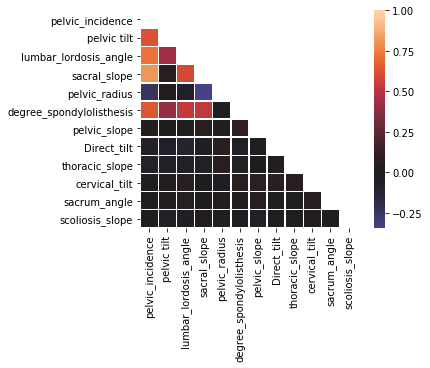

In [0]:
corr_back = back_data.corr()
# Generate a mask for the upper right triangle of the square - one half is enough to convey the correlation 
## between the predictors
mask = np.zeros_like(corr_back, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate the correlation plot 
sns.heatmap(corr_back, mask=mask, center=0, square=True, linewidths=.5)

plt.show()

In [0]:
# Seeing the correlation values
corr_back

,pelvic_incidence,pelvic tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
pelvic_incidence,1.000000,0.629199,0.717282,0.814960,-0.247467,0.638743,0.043290,-0.078411,-0.089740,0.016750,0.019240,-0.007251
pelvic tilt,0.629199,1.000000,0.432764,0.062345,0.032668,0.397862,0.008852,-0.072119,-0.063394,0.028931,0.032859,-0.056550
lumbar_lordosis_angle,0.717282,0.432764,1.000000,0.598387,-0.080344,0.533667,0.029486,-0.112939,-0.063582,0.063875,0.057199,-0.049054
sacral_slope,0.814960,0.062345,0.598387,1.000000,-0.342128,0.523557,0.048988,-0.046914,-0.067968,-0.000063,0.000207,0.032853
pelvic_radius,-0.247467,0.032668,-0.080344,-0.342128,1.000000,-0.026065,0.015767,0.063433,0.060477,-0.039800,0.029738,-0.030145
degree_spondylolisthesis,0.638743,0.397862,0.533667,0.523557,-0.026065,1.000000,0.085925,-0.063812,-0.057286,0.056576,0.023021,-0.041023
pelvic_slope,0.043290,0.008852,0.029486,0.048988,0.015767,0.085925,1.000000,0.012694,-0.011770,0.088017,0.060743,-0.073893
Direct_tilt,-0.078411,-0.072119,-0.112939,-0.046914,0.063433,-0.063812,0.012694,1.000000,0.009887,0.072738,-0.037428,-0.024021
thoracic_slope,-0.089740,-0.063394,-0.063582,-0.067968,0.060477,-0.057286,-0.011770,0.009887,1.000000,0.052451,0.011354,0.009541
cervical_tilt,0.016750,0.028931,0.063875,-0.000063,-0.039800,0.056576,0.088017,0.072738,0.052451,1.000000,0.057451,0.021243


## Bi-variate analysis - Relation of each predictor with Target variable

The status column has two values - 'Abnormal' and 'Normal'. We would like to explore how each of the 12 predictor variables vary with respect to the Status value. We would be more interested in those predictor variables which have a noticeable difference in their values corresponding to 'Normal' and 'Abnormal'. 

We calculate the mean/ median of values corresponding to Normal and Abnormal for each of the predictor variables. Some observations:

 - The first six variables have noticeable difference in the means corresponding to Normal and Abnormal.
 - The mean corresponding to Abnormal for degree_spondylolisthesis is quite higher than the corresponding median. Could be due to outliers.
 - pelvic_radius has lower values for Abnormal as compared to Normal.

In [0]:
back_data.groupby('Status').mean()

,pelvic_incidence,pelvic tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
Status,,,,,,,,,,,,
Abnormal,64.692562,19.791111,55.925370,44.90145,115.077713,37.777705,0.483979,21.085875,12.948913,12.132737,-13.826677,25.146915
Normal,51.685244,12.821414,43.542605,38.86383,123.890834,2.186572,0.449880,21.816394,13.307268,11.514534,-14.528711,26.694019


In [0]:
back_data.groupby('Status').median()

,pelvic_incidence,pelvic tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
Status,,,,,,,,,,,,
Abnormal,65.274888,18.798899,56.150000,44.639597,115.650323,31.946516,0.501280,21.7506,12.77005,11.973735,-14.892070,24.50940
Normal,50.123115,13.482435,42.638923,37.059694,123.874328,1.152710,0.418732,22.4146,13.40975,11.330750,-13.974694,27.72795


### Box Plots
To visualise the above data exploration, we make use of Box Plots as we are comparing Categorical and continuous variables.

A couple of observations which jump out:
 - For the variable degree_spondilolisthesis, 'Normal' status clearly has a much lower range of values as compared to 'Abnormal'. Also shows the presence of a distant outlier. Not removing the outlier - as without domain knowledge, it would be hard to interpret whether it is an incorrect or a rare value.
 - For the variable 'Pelvic Radius' while 'Abnormal' has a much higher range of values, the median value of 'Abnormal' is lower than the median values of 'Normal'.

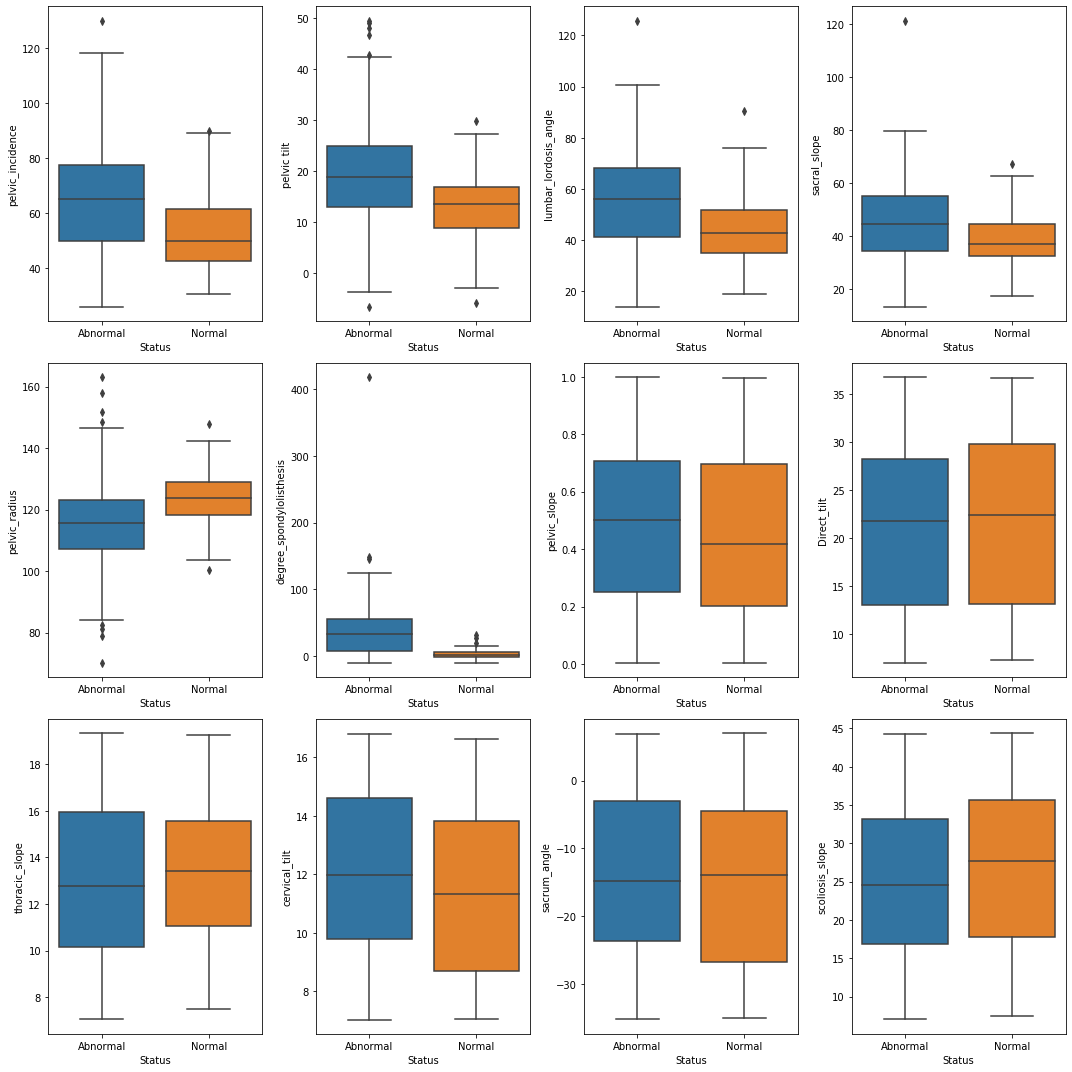

In [0]:
## Generating 3*4 matrix of box plots
fig, axes = plt.subplots(3, 4, figsize = (15,15))
axes = axes.flatten()

for i in range(0,len(back_data.columns)-1):
    sns.boxplot(x="Status", y=back_data.iloc[:,i], data=back_data, orient='v', ax=axes[i])

plt.tight_layout()
plt.show()

## Final processing

 - For modelling purpose, we map all the predictor variables to a array X and the target variable to an array Y. 
 - The class labels 'Abnormal' and 'Normal' are numerically encoded to 1 and 0. While this is not necessary as the sklearn module can handle it internally, it is convenient for graphing the Receiver Operating curve (if required).
 - The variables are subjected to Standardization (mean zero and unit variance) before being fed to the model.

In [0]:
back_data.loc[back_data.Status=='Abnormal','Status'] = 1
back_data.loc[back_data.Status=='Normal','Status'] = 0

In [0]:
X = back_data.loc[:, back_data.columns != "Status"]
y = back_data.loc[:, back_data.columns == "Status"]

## Modelling and Feature Interpretation

 - Implementing a logistic regression classifier with a train test split in a 70:30 ratio. 
 - The fitted model when applied on the test data returns an accuracy of 81.7%. 

In [0]:
def data_preprocess(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.3, random_state=0)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)

    scaler.fit(X_train)

    # Now apply the transformations to the data:
    train_scaled = scaler.transform(X_train)
    test_scaled = scaler.transform(X_test)
    return(train_scaled, test_scaled, y_train, y_test)

In [0]:
def logistic_regression(x,y):
    logreg = LogisticRegression().fit(x, y)
    return(logreg)

In [0]:
X_train_scaled, X_test_scaled, y_train, y_test = data_preprocess(X,y)

logreg_result = logistic_regression(X_train_scaled, y_train)

print("Training set score: {:.3f}".format(logreg_result.score(X_train_scaled,y_train)))
print("Test set score: {:.3f}".format(logreg_result.score(X_test_scaled,y_test)))

Training set score: 0.876
Test set score: 0.817


## To explain or to predict

 - While the previous model implemented was good in predicting the Target variable on a test set, we did not interpret anything about the individual features - which variable(s) influence the Target variable more. 
 - Since this is a medical dataset, there could be a need for explaining the effect of individual variables on the response variable. Hence it would be a good idea to explore the model co-efficients of the predictor variables to see how well each of them influence the response. 
 - Let us attempt this in the next section.

In [0]:
logit_model = sm.Logit(y_train, X_train_scaled)
result = logit_model.fit()
print(result.summary2())

         Current function value: 0.473055
         Iterations: 35
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.248     
Dependent Variable:  y                 AIC:               229.3058  
Date:                2020-01-09 08:08  BIC:               269.8646  
No. Observations:    217               Log-Likelihood:    -102.65   
Df Model:            11                LL-Null:           -136.45   
Df Residuals:        205               LLR p-value:       3.4943e-10
Converged:           0.0000            Scale:             1.0000    
No. Iterations:      35.0000                                        
--------------------------------------------------------------------
     Coef.    Std.Err.      z    P>|z|      [0.025         0.975]   
--------------------------------------------------------------------
x1   0.0814 9455046.8626  0.0000 1.0000 -18531551.2414 18531551.4041
x2   0.0765 5389326.3090  0.0000 1.0000 -10562885.3901 10562885.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## Understanding the model result summary

 - The above model did not converge because some variables were highly correlated with each other and this would have led to the correlation/ covariance matrix to be singular. 
 - A matrix can become singular if any rows(columns) can be expressed as a linear combination of any other rows (columns). 
 - In fact, it was very intersting to note that in our data, the Pelvic Incidence column values are an exact sum of Pelvic Tilt and Sacral Slope. So that explains.
 - Also in our statistical test results, the Standard error values are very high and p-value is 1 for these three variables. Hence we will remove them and re run the model. 

In [0]:
#Removing the highly correlated variables which also had high standard error
cols_to_include = [cols for cols in X.columns if cols not in ['pelvic_incidence', 'pelvic tilt','sacral_slope']]
X = back_data[cols_to_include]

In [0]:
X_train_scaled, X_test_scaled, y_train, y_test = data_preprocess(X,y)

logreg_result = logistic_regression(X_train_scaled, y_train)

print("Training set score: {:.3f}".format(logreg_result.score(X_train_scaled,y_train)))
print("Test set score: {:.3f}".format(logreg_result.score(X_test_scaled,y_test)))

Training set score: 0.848
Test set score: 0.753


The test results indicate that the predictive power has gone down after removing the highly correlated variables. Let us look at the statistical summary below.

In [0]:
# to get the statistical summary of the new model
logit_model=sm.Logit(y_train,X_train_scaled)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.481933
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.234     
Dependent Variable: y                AIC:              227.1591  
Date:               2020-01-09 08:08 BIC:              257.5781  
No. Observations:   217              Log-Likelihood:   -104.58   
Df Model:           8                LL-Null:          -136.45   
Df Residuals:       208              LLR p-value:      8.5613e-11
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
--------------------------------------------------------------------
       Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
--------------------------------------------------------------------
x1    -0.5434      0.2568    -2.1158    0.0344    -1.0468    -0.0400
x2    -0.9642      0.2080    -4.6364    0.0000    -1.3

## Model convergence
- The model has now converged after removing the highly correlated variables.
- There are a few predictors with p-values less than 0.05 (assuming a 95% confidence level). Let us consider only those predictors and re run the model

In [0]:
# considering only the variables which have p-value less than 0.05
X_trim_1 = X.loc[:,['lumbar_lordosis_angle','pelvic_radius','degree_spondylolisthesis']]

## Final Model Selection

- The test result below indicate that there is a marginal increase in predictive power - the accuracy on the test set has increased from 74% to 77%. 
- This can be our final chosen model (even though Variable 1 - lumbar_lordosis_angle has a p-value marginally greater than 0.05). 


In [0]:
X_train_scaled, X_test_scaled, y_train, y_test = data_preprocess(X_trim_1,y)

logreg_result = logistic_regression(X_train_scaled, y_train)

print("Training set score: {:.3f}".format(logreg_result.score(X_train_scaled,y_train)))
print("Test set score: {:.3f}".format(logreg_result.score(X_test_scaled,y_test)))

Training set score: 0.857
Test set score: 0.774


In [0]:
logit_model=sm.Logit(y_train,X_train_scaled)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.498420
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.207     
Dependent Variable: y                AIC:              222.3145  
Date:               2020-01-09 08:08 BIC:              232.4542  
No. Observations:   217              Log-Likelihood:   -108.16   
Df Model:           2                LL-Null:          -136.45   
Df Residuals:       214              LLR p-value:      5.1622e-13
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
--------------------------------------------------------------------
       Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
--------------------------------------------------------------------
x1    -0.4688      0.2426    -1.9325    0.0533    -0.9443     0.0067
x2    -0.9188      0.2037    -4.5100    0.0000    -1.3

## Interpreting the causative power of the predictors

- Now that we have decided on our final model, let us interpret the co-efficient estimates of the three predictor variables from the above statistical summary. 
    - Both lumbar_lordosis_angle and pelvic_radius have a negative co-efficient indicating that for every unit increase in the values of these variables, the log of odds of the Status being Abnormal decreases. 
    - degree_spondylolisthesis has a positive relationship with Abnormal status i.e for every unit increase in the value of degree_spondylolisthesis the log of odds of the Status being Abnormal increases.

In [0]:
# assigning the model predicted values to y_pred
y_pred = logreg_result.predict(X_test_scaled)

# assigning the string Normal and Abnormal to the 0 and 1 values respectively. This is useful in plotting 
# the confusion matrix
y_pred_string = y_pred.astype(str)
y_pred_string[np.where(y_pred_string == '0')] = 'Normal'
y_pred_string[np.where(y_pred_string == '1')] = 'Abnormal'

y_test_string = y_test.astype(str)
y_test_string[np.where(y_test_string == '0')] = 'Normal'
y_test_string[np.where(y_test_string == '1')] = 'Abnormal'

## Sensitivity and Specificity

From the confusion matrix, we can calculate the Sensitivity True Positive/ (True positive + False Negative) and Specificity - True Negative / (True Negative + False Positive). 
Sensitivity = 74.6% and Specificity = 76.6%

I am not quite sure in this specific problem context, which one should be given more importance (or should have a higher value). 

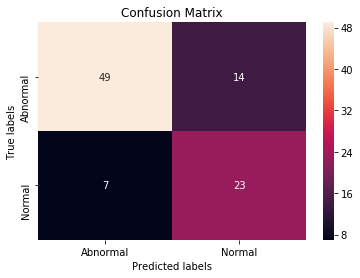

In [0]:
from sklearn.metrics import confusion_matrix
ax= plt.subplot()
labels = ['Abnormal','Normal']
cm = confusion_matrix(y_test_string, y_pred_string, labels)
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Abnormal', 'Normal']); ax.yaxis.set_ticklabels(['Abnormal', 'Normal']);
plt.show()

### Thanks for coming along all the way. Would love to hear inputs for improvement. Thanks.